In [15]:
import pandas as pd
import os
import numpy as np

In [6]:
folder_path = "data"
all_dfs = []

In [7]:
for file in os.listdir(folder_path):
    if file.endswith(".pkl"):
        file_path = os.path.join(folder_path,file)
        df = pd.read_pickle(file_path)
        all_dfs.append(df)



In [8]:
df = pd.concat(all_dfs, ignore_index=True)    


In [10]:
print(f"Final dataset shape:{df.shape}")

Final dataset shape:(1754155, 9)


In [11]:
print(df.describe())

       TRANSACTION_ID                    TX_DATETIME     TX_AMOUNT  \
count    1.754155e+06                        1754155  1.754155e+06   
mean     8.770770e+05  2018-07-01 11:20:33.708572160  5.363230e+01   
min      0.000000e+00            2018-04-01 00:00:31  0.000000e+00   
25%      4.385385e+05     2018-05-16 14:40:46.500000  2.101000e+01   
50%      8.770770e+05            2018-07-01 11:11:10  4.464000e+01   
75%      1.315616e+06     2018-08-16 08:01:01.500000  7.695000e+01   
max      1.754154e+06            2018-09-30 23:59:57  2.628000e+03   
std      5.063811e+05                            NaN  4.232649e+01   

           TX_FRAUD  TX_FRAUD_SCENARIO  
count  1.754155e+06       1.754155e+06  
mean   8.369272e-03       1.882388e-02  
min    0.000000e+00       0.000000e+00  
25%    0.000000e+00       0.000000e+00  
50%    0.000000e+00       0.000000e+00  
75%    0.000000e+00       0.000000e+00  
max    1.000000e+00       3.000000e+00  
std    9.110012e-02       2.113263e-01  


In [12]:
print(df['TX_FRAUD'].value_counts())

TX_FRAUD
0    1739474
1      14681
Name: count, dtype: int64


In [13]:
df["TX_DATETIME"] = pd.to_datetime(df["TX_DATETIME"])
df["hour"] = df["TX_DATETIME"].dt.hour
df["day"] = df["TX_DATETIME"].dt.day
df["month"] = df["TX_DATETIME"].dt.month


In [16]:
df["log_amount"] = df["TX_AMOUNT"].apply(lambda x: np.log(x + 1))


In [17]:
df["customer_tx_count"] = df.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("count")
df["customer_avg_tx"] = df.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("mean")


In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


df = df.drop(columns=["TRANSACTION_ID", "TX_DATETIME"])  


label_enc = LabelEncoder()
df["CUSTOMER_ID"] = label_enc.fit_transform(df["CUSTOMER_ID"])
df["TERMINAL_ID"] = label_enc.fit_transform(df["TERMINAL_ID"])


scaler = StandardScaler()
df["TX_AMOUNT_SCALED"] = scaler.fit_transform(df[["TX_AMOUNT"]])


In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["TX_FRAUD"]) 
y = df["TX_FRAUD"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    347895
           1       1.00      1.00      1.00      2936

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831

ROC-AUC Score: 1.0


In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [26]:
import pickle

with open("fraud_detection_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [27]:
with open("fraud_detection_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    347895
           1       1.00      1.00      1.00      2936

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831

ROC-AUC Score: 1.0


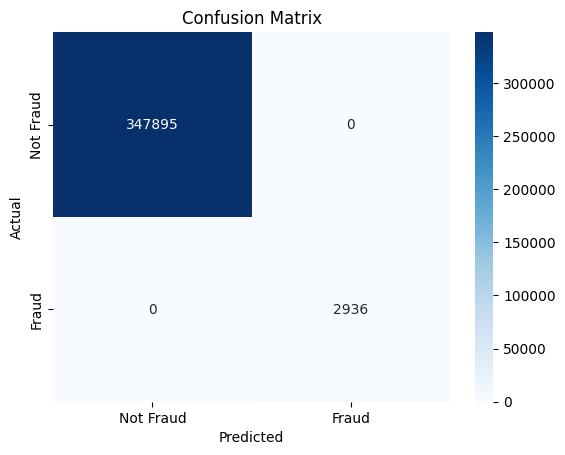

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on test data
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score (Measures fraud detection capability)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [51]:
# Load a new transaction dataset (or manually create a sample)
new_data = pd.read_pickle("2018-05-28.pkl")  # Replace with actual new data file


# Preprocess new data (use same transformations as before)
new_data["hour"] = pd.to_datetime(new_data["TX_DATETIME"]).dt.hour
new_data["day"] = pd.to_datetime(new_data["TX_DATETIME"]).dt.day
new_data["month"] = pd.to_datetime(new_data["TX_DATETIME"]).dt.month
new_data["log_amount"] = new_data["TX_AMOUNT"].apply(lambda x: np.log(x + 1))

new_data["customer_tx_count"] = new_data.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("count")
new_data["customer_avg_tx"] = new_data.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("mean")

new_data["TX_AMOUNT_SCALED"] = scaler.transform(new_data[["TX_AMOUNT"]])
new_data = new_data.drop(columns=["TRANSACTION_ID", "TX_DATETIME","TX_FRAUD"])
# Recompute missing features




# Customer-based features (ensure same aggregation method)


# Make predictions
predictions = model.predict(new_data)

# Add predictions to DataFrame
new_data["Fraud_Prediction"] = predictions

# Show fraudulent transactions detected
fraud_cases = new_data[new_data["Fraud_Prediction"] == 1]
print(fraud_cases)


       CUSTOMER_ID TERMINAL_ID  TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  \
547195        3567        7476      77.55         4925456           57   
547250        4959        9745       8.41         4927973           57   
547275        2938         373     115.65         4929040           57   
547370        4947        6377      22.48         4931611           57   
547373        1795        1003      37.37         4931659           57   
...            ...         ...        ...             ...          ...   
556408         469        9102     112.35         5000763           57   
556591        3076        1909     132.03         5004860           57   
556629        3850        5438      24.40         5005920           57   
556675         885        7868      23.21         5007845           57   
556751        3739        2574      64.60         5010804           57   

        TX_FRAUD_SCENARIO  hour  day  month  log_amount  customer_tx_count  \
547195                  2     0  

In [50]:
print(fraud_cases)

     CUSTOMER_ID TERMINAL_ID  TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  \
3527        3774        3059     225.41           37063            0   
5790        4944        6050     222.26           48708            0   
6549        4625        9102     226.40           52922            0   

      TX_FRAUD_SCENARIO  hour  day  month  log_amount  customer_tx_count  \
3527                  1    10    1      4    5.422348                  6   
5790                  1    13    1      4    5.408337                  2   
6549                  1    14    1      4    5.426711                  4   

      customer_avg_tx  TX_AMOUNT_SCALED  Fraud_Prediction  
3527       127.238333          4.058398                 1  
5790       127.605000          3.983976                 1  
6549       167.165000          4.081788                 1  
